# Maryam Hosseinali - 610398209

# polyp segmentation and detection using U-Net and YOLOv5

In [1]:
# import needed libraries

import tensorflow as tf # is needed for building and training segmentation network
import os # needed to moving in addressses and reading images based on their adresses
import random
import numpy as np

# to resize images (cause their sizes are different)
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

import cv2
# a seed value for results reproduction
seed = 42
np.random.seed = seed

# dimensions and channels for images to standard their size 
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_CHANNELS = 3

In [2]:
# arrays to hold the training images and corresponding masks
train_ids = 1000

X_train = np.zeros((train_ids, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),dtype=np.uint8)
# X's are our images 
Y = np.zeros((train_ids, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((train_ids, IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
# Y's are our masks and they are black and white


# Loop through images in the 'images' folder, read and resize them
n = 0
for filename in os.listdir('./images/'):   
    #reading images in colors (we will convert it to 1 dimension images (black and white))
    img = imread("./images/" + filename) 
    # resizing images
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  

    # reading masks
    mask = imread("./masks/" + filename) 
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    Y[n] = mask  #int8 type
    # convert masks from 3D (RGB) to 1D (Gray) they are naturally balck and white but we read them RGB so its needed to convert
    # their dimension to 1D
    Y_train[n] = cv2.cvtColor(Y[n], cv2.COLOR_BGR2GRAY)[:, :, np.newaxis].astype(dtype=bool) #boolean type

    n+=1

In [3]:
# apply data augmentation to the dataset for better generalization
# i used data augmentation to generate new data based on the original data
import albumentations as alb

# function to do augmentations
augmentor = alb.Compose([alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), # it makes images a bit noisy
                         alb.VerticalFlip(p=0.5)])

# empty arrays to store augmented images and masks
X_train_aug = np.zeros((0, 224, 224, 3))
Y_train_aug = np.zeros((0, 224, 224, 1))  

# perform the augmentation on the dataset
for batch in range(1):
    augmented = augmentor(image=X_train, mask=Y_train)
    
    X_batch = augmented['image'] 
    Y_batch = augmented['mask']

    # add augmented images and masks to the previously created arrays
    X_train_aug = np.concatenate((X_train_aug, X_batch)) 
    Y_train_aug = np.concatenate((Y_train_aug, Y_batch)) 

# combine the original and augmented datasets to mkae final training dataset
X_train_final = np.concatenate((X_train, X_train_aug)).astype(np.uint8)
Y_train_final = np.concatenate((Y_train, Y_train_aug))

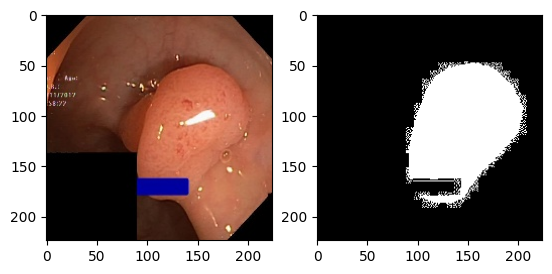

In [4]:
# this section is just to make sure the data is loaded correctly and the images
# and their corresponding masks are sync

image_x = random.randint(0, X_train_final.shape[0])

image = X_train_final[image_x]
mask = Y_train_final[image_x].squeeze() 


fig, (ax1, ax2) = plt.subplots(1, 2)

# plot image
ax1.imshow(image)  

# plot mask
ax2.imshow(mask, cmap='gray')  

plt.show()

In [5]:
# defining U-Net model architecture

inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

#Defining model input (image) and output (mask) 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
#Compiling model with proper optimizer, adam is a good choice
#Use binary_crossentropy as loss function because of 2 class classification task
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 32)         896       ['lambda[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 224, 224, 32)         0         ['conv2d[0][0]']              
                                                                                           

In [6]:
# load pre-trained weights
model.load_weights("./augsegmentation8.keras")

In [ ]:
# compile and fit model on the training data, perform validation split and set the number of epochs

results = model.fit(X_train_final, Y_train_final, validation_split=0.2, batch_size=10, epochs=5)

In [7]:
idx = random.randint(0, X_train_final.shape[0])

# predict on train and validation data
preds_train = model.predict(X_train_final[:int(X_train_final.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train_final[int(X_train_final.shape[0]*0.9):], verbose=1)

7/7 [==============================] - 37s 5s/step


726


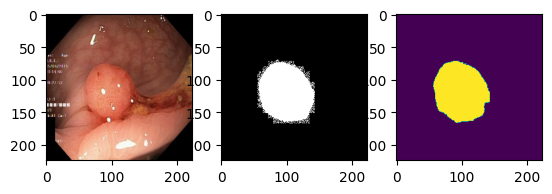

In [8]:
# a threshold to the predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

# select a random image from the training set for visualization
image_x = random.randint(0, X_train_final.shape[0]*0.9)

print(image_x)

image = X_train_final[image_x]
mask = Y_train_final[image_x].squeeze() 
predictmask = preds_train_t[image_x].squeeze() 

 
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)

# Plot image
ax1.imshow(image)  

# Plot mask
ax2.imshow(mask, cmap='gray') 

ax3.imshow(predictmask)

plt.show()

In [ ]:
model.save('./aug.keras') 
